In [1]:
!pip install --quiet --upgrade transformers
!pip install --quiet huggingface_hub[hf_xet]
!pip install --quiet nltk
!pip install --quiet seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 69.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 34.2 MB/s eta 0:00:00:00:0100:01


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.amp import autocast, GradScaler
from transformers import DistilBertTokenizer, DistilBertModel, get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
import nltk
from nltk.corpus import wordnet
import warnings

In [ ]:
warnings.filterwarnings("ignore", message="Unable to register cuFFT factory")
warnings.filterwarnings("ignore", message="Unable to register cuDNN factory")
warnings.filterwarnings("ignore", message="Unable to register cuBLAS factory")

RandomState = 2022484
np.random.seed(RandomState)
random.seed(RandomState)
torch.manual_seed(RandomState)

DEVICE = torch.device("cuda")
torch.backends.cudnn.benchmark = True

In [ ]:
def LoadPubmedRctFile(FilePath):
    Cases = []
    with open(FilePath, "r", encoding="utf-8") as Fobj:
        Case = {"label": None, "text": ""}
        for Line in Fobj:
            Line = Line.strip()
            if Line == "":
                if Case["label"] and Case["text"]:
                    Cases.append(Case)
                Case = {"label": None, "text": ""}
            elif Line.split("\t")[0].isupper():
                if Case["label"] and Case["text"]:
                    Cases.append(Case)
                Parts = Line.split("\t")
                Case = {"label": Parts[0], "text": Parts[1]}
            else:
                Case["text"] += " " + Line.strip()
        if Case["label"] and Case["text"]:
            Cases.append(Case)

    DF = pd.DataFrame(Cases)
    print(f"Dataset loaded with {len(DF)} samples.")
    print(DF.head())
    return DF

In [ ]:
class LoadPubmedRct:
    def __init__(self, FilePath):
        self.DataFrame = LoadPubmedRctFile(FilePath)
    def GetDataFrame(self):
        return self.DataFrame

class SplitTrainTestVal:
    def __init__(self, DataFrame):
        self.DataFrame = DataFrame
    def Split(self):
        TrainData, TempData = train_test_split(
            self.DataFrame,
            test_size=0.2,
            stratify=self.DataFrame["label"],
            random_state=RandomState
        )
        ValData, TestData = train_test_split(
            TempData,
            test_size=0.5,
            stratify=TempData["label"],
            random_state=RandomState
        )
        print("Train:", len(TrainData), "Val:", len(ValData), "Test:", len(TestData))
        return TrainData, ValData, TestData

In [ ]:
def PlotClassDistribution(DF):
    plt.figure(figsize=(8,5))
    sns.countplot(data=DF, x="label", order=DF["label"].value_counts().index)
    plt.title("Class Distribution in PubMed-RCT")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
class AugSynonymReplace:
    def __init__(self, Probability=0.15):
        self.Probability = Probability
    def __call__(self, Text):
        Words = Text.split()
        NewWords = []
        for W in Words:
            if random.random() < self.Probability:
                Syns = wordnet.synsets(W)
                if Syns:
                    Lemmas = Syns[0].lemmas()
                    if Lemmas:
                        Synonym = Lemmas[0].name()
                        if Synonym != W:
                            NewWords.append(Synonym)
                            continue
            NewWords.append(W)
        return " ".join(NewWords)

class AugRandomMask:
    def __init__(self, Tokenizer, Probability=0.10):
        self.Tokenizer = Tokenizer
        self.Probability = Probability
    def __call__(self, Text):
        Tokens = self.Tokenizer.tokenize(Text)
        if not Tokens:
            return Text
        NumMask = max(1, int(len(Tokens)*self.Probability))
        for _ in range(NumMask):
            Idx = random.randint(0, len(Tokens)-1)
            Tokens[Idx] = self.Tokenizer.mask_token
        return self.Tokenizer.convert_tokens_to_string(Tokens)

class AugRandomDelete:
    def __init__(self, Probability=0.15):
        self.Probability = Probability
    def __call__(self, Text):
        Words = Text.split()
        NewWords = []
        for W in Words:
            if random.random() < self.Probability:
                continue
            NewWords.append(W)
        return " ".join(NewWords)

class AugRandomSwap:
    def __init__(self, Probability=0.15):
        self.Probability = Probability
    def __call__(self, Text):
        Words = Text.split()
        if len(Words) < 2:
            return Text
        if random.random() < self.Probability:
            i = random.randint(0, len(Words)-1)
            j = random.randint(0, len(Words)-1)
            while j == i:
                j = random.randint(0, len(Words)-1)
            Words[i], Words[j] = Words[j], Words[i]
        return " ".join(Words)

In [ ]:
class WeakAugText_Sequence:
    def __init__(self, Tokenizer):
        self.synReplace = AugSynonymReplace(Probability=0.1)
        self.maskAug    = AugRandomMask(Tokenizer, Probability=0.1)
    def __call__(self, Text):
        out = self.synReplace(Text)
        out = self.maskAug(out)
        return out

class MediumAugText_Sequence:
    def __init__(self):
        self.synReplace = AugSynonymReplace(Probability=0.15)
        self.deleteAug  = AugRandomDelete(Probability=0.10)
        self.swapAug    = AugRandomSwap(Probability=0.10)
    def __call__(self, Text):
        out = self.synReplace(Text)
        out = self.deleteAug(out)
        out = self.swapAug(out)
        return out

class StrongAugText_Sequence:
    def __init__(self, Tokenizer):
        self.synReplace = AugSynonymReplace(Probability=0.2)
        self.deleteAug  = AugRandomDelete(Probability=0.2)
        self.swapAug    = AugRandomSwap(Probability=0.2)
        self.maskAug    = AugRandomMask(Tokenizer, Probability=0.2)
    def __call__(self, Text):
        out = self.synReplace(Text)
        out = self.deleteAug(out)
        out = self.swapAug(out)
        out = self.maskAug(out)
        return out

In [ ]:
class PubmedRctSequenceMatchDataset(Dataset):
    def __init__(self, DataFrame, Tokenizer, MaxLen=128, IsUnlabeled=False):
        super().__init__()
        self.Df = DataFrame.reset_index(drop=True)
        self.Tokenizer = Tokenizer
        self.MaxLen = MaxLen
        self.IsUnlabeled = IsUnlabeled

        self.LabelList = sorted(self.Df["label"].unique())
        self.Label2Idx = {lab: i for i,lab in enumerate(self.LabelList)}

        self.WeakAug = WeakAugText_Sequence(Tokenizer)
        self.MedAug  = MediumAugText_Sequence()
        self.StrAug  = StrongAugText_Sequence(Tokenizer)

    def __len__(self):
        return len(self.Df)

    def __getitem__(self, idx):
        Row = self.Df.iloc[idx]
        Text= Row["text"]
        LblStr = Row["label"]
        Lbl = self.Label2Idx[LblStr]

        OrigEnc = self.Tokenizer.encode_plus(
            Text,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )

        WText = self.WeakAug(Text)
        WEnc  = self.Tokenizer.encode_plus(
            WText,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )

        MText = self.MedAug(Text)
        MEnc  = self.Tokenizer.encode_plus(
            MText,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )

        SText = self.StrAug(Text)
        SEnc  = self.Tokenizer.encode_plus(
            SText,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )

        if self.IsUnlabeled:
            Lbl = -1

        return {
            "OriginalIds": OrigEnc["input_ids"].squeeze(0),
            "OriginalMask": OrigEnc["attention_mask"].squeeze(0),

            "WeakIds":   WEnc["input_ids"].squeeze(0),
            "WeakMask":  WEnc["attention_mask"].squeeze(0),

            "MedIds":    MEnc["input_ids"].squeeze(0),
            "MedMask":   MEnc["attention_mask"].squeeze(0),

            "StrongIds": SEnc["input_ids"].squeeze(0),
            "StrongMask":SEnc["attention_mask"].squeeze(0),

            "Label": Lbl
        }


In [ ]:
class PubmedRctTestDataset(Dataset):
    def __init__(self, DataFrame, Tokenizer, MaxLen=128):
        super().__init__()
        self.Df = DataFrame.reset_index(drop=True)
        self.Tokenizer = Tokenizer
        self.MaxLen = MaxLen
        self.LabelList = sorted(self.Df["label"].unique())
        self.Label2Idx = {lab: i for i,lab in enumerate(self.LabelList)}

    def __len__(self):
        return len(self.Df)

    def __getitem__(self, idx):
        Row = self.Df.iloc[idx]
        Text= Row["text"]
        LblStr= Row["label"]
        Lbl   = self.Label2Idx[LblStr]

        Enc = self.Tokenizer.encode_plus(
            Text,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )
        return {
            "InputIds": Enc["input_ids"].squeeze(0),
            "AttentionMask": Enc["attention_mask"].squeeze(0),
            "Label": Lbl
        }

In [ ]:
class DistilBertSequenceMatch(nn.Module):
    def __init__(self, NumLabels):
        super().__init__()
        self.Backbone = DistilBertModel.from_pretrained("distilbert-base-uncased")
        HiddenSize = self.Backbone.config.dim
        self.Classifier = nn.Linear(HiddenSize, NumLabels)

    def forward(self, InputIds, AttentionMask):
        Out = self.Backbone(InputIds, attention_mask=AttentionMask)
        HiddenState = Out.last_hidden_state[:,0,:]
        Logits = self.Classifier(HiddenState)
        return Logits

In [ ]:
class TrainSequenceMatchText:
    def __init__(
        self,
        Model,
        LabeledLoader,
        UnlabeledLoader,
        ValLoader,
        TestLoader,
        LabelList,
        Epochs=3,
        Lr=2e-5,
        Tau=0.95,
        LambdaU=0.8,
        KLWeight=0.1,
        Eps=1e-8,
        Device=DEVICE,
        RunName="SeqRun"
    ):
        self.Model = Model.to(Device)
        self.LabeledLoader = LabeledLoader
        self.UnlabeledLoader= UnlabeledLoader
        self.ValLoader = ValLoader
        self.TestLoader= TestLoader

        self.LabelList = LabelList
        self.NumLabels = len(LabelList)

        self.Epochs = Epochs
        self.Lr = Lr
        self.Tau= Tau
        self.LambdaU = LambdaU
        self.KLWeight= KLWeight
        self.Eps= Eps
        self.Device= Device
        self.RunName= RunName

    def Run(self):
        optimizer = optim.AdamW(self.Model.parameters(), lr=self.Lr)
        totalSteps= self.Epochs * len(self.LabeledLoader)
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=0, num_training_steps=totalSteps
        )
        scaler = GradScaler()

        TrainLossList= []
        TrainSupLossList= []
        TrainUnsupLossList= []
        TrainAccList= []
        ValLossList= []
        ValAccList= []

        for ep in range(self.Epochs):
            self.Model.train()
            totalLoss=0.
            supLossSum=0.
            unsupLossSum=0.
            correctSup=0
            totalSup=0
            nBatch=0

            unIter = iter(self.UnlabeledLoader)
            for lbBatch in tqdm(self.LabeledLoader, desc=f"{self.RunName} E{ep+1}/{self.Epochs}", leave=False):
                WIds  = lbBatch["WeakIds"].to(self.Device)
                WMask = lbBatch["WeakMask"].to(self.Device)
                labs  = lbBatch["Label"].to(self.Device)

                with autocast(device_type="cuda"):
                    logitsL = self.Model(WIds, WMask)
                    supLoss= F.cross_entropy(logitsL, labs)

                predsL= torch.argmax(logitsL,dim=1)
                correctSup += (predsL==labs).sum().item()
                totalSup   += labs.size(0)

                try:
                    ub = next(unIter)
                except StopIteration:
                    unIter = iter(self.UnlabeledLoader)
                    ub = next(unIter)

                UWIds  = ub["WeakIds"].to(self.Device)
                UWMask = ub["WeakMask"].to(self.Device)
                UMIds  = ub["MedIds"].to(self.Device)
                UMMask = ub["MedMask"].to(self.Device)
                USIds  = ub["StrongIds"].to(self.Device)
                USMask = ub["StrongMask"].to(self.Device)

                with torch.no_grad(), autocast(device_type="cuda"):
                    logitsWeak= self.Model(UWIds, UWMask)
                    distWeak = F.softmax(logitsWeak,dim=1)

                maxProbs, hardLabel = torch.max(distWeak, dim=1)
                hiConfMask = (maxProbs >= self.Tau).float()

                with autocast(device_type="cuda"):
                    logitsMed= self.Model(UMIds, UMMask)
                    distMed  = F.softmax(logitsMed, dim=1)
                    logitsStr= self.Model(USIds, USMask)
                    distStr  = F.softmax(logitsStr, dim=1)

                T=0.5
                wSharp = distWeak**(1./T)
                wSharp = wSharp / (wSharp.sum(dim=1,keepdim=True)+self.Eps)

                ceHard = F.cross_entropy(logitsStr, hardLabel, reduction="none")
                logStr = F.log_softmax(logitsStr, dim=1)
                ceSoft = -(wSharp*logStr).sum(dim=1)

                unsupCE = hiConfMask*ceHard + (1.-hiConfMask)*ceSoft
                unsupCE = unsupCE.mean()

                def kl_div(p,q):
                    return (p*(p.add(self.Eps).log()-q.add(self.Eps).log())).sum(dim=1)

                wSharpDet = wSharp.detach()
                KL_w_m = hiConfMask * kl_div(wSharpDet, distMed)
                KL_m_s = hiConfMask * kl_div(distMed, distStr)
                KL_w_s = hiConfMask * kl_div(wSharpDet, distStr)

                KL_w_m = KL_w_m.mean()
                KL_m_s = KL_m_s.mean()
                KL_w_s = KL_w_s.mean()

                sumKL = (KL_w_m + KL_m_s + KL_w_s)*self.KLWeight

                unsupLoss = unsupCE + sumKL
                finalLoss = supLoss + self.LambdaU*unsupLoss

                optimizer.zero_grad()
                scaler.scale(finalLoss).backward()
                torch.nn.utils.clip_grad_norm_(self.Model.parameters(),1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                totalLoss+= finalLoss.item()
                supLossSum+= supLoss.item()
                unsupLossSum+= unsupLoss.item()
                nBatch+=1

            avgTot= totalLoss/nBatch
            avgSup= supLossSum/nBatch
            avgUnsup= unsupLossSum/nBatch
            trainAcc= correctSup / (totalSup+1e-8)

            TrainLossList.append(avgTot)
            TrainSupLossList.append(avgSup)
            TrainUnsupLossList.append(avgUnsup)
            TrainAccList.append(trainAcc)

            self.Model.eval()
            vLoss=0.
            vB=0
            vPreds=[]
            vLabs=[]
            with torch.no_grad():
                for vb in self.ValLoader:
                    i_= vb["InputIds"].to(self.Device)
                    m_= vb["AttentionMask"].to(self.Device)
                    l_= vb["Label"].to(self.Device)
                    with autocast(device_type="cuda"):
                        outV= self.Model(i_,m_)
                        lv= F.cross_entropy(outV, l_)
                    vLoss+= lv.item()
                    vB+=1
                    preds_= torch.argmax(outV,dim=1)
                    vPreds.extend(preds_.cpu().numpy())
                    vLabs.extend(l_.cpu().numpy())

            avgValLoss= vLoss/vB
            valAcc= accuracy_score(vLabs, vPreds)

            ValLossList.append(avgValLoss)
            ValAccList.append(valAcc)

            print(f"{self.RunName} Epoch[{ep+1}/{self.Epochs}] "
                  f"TrainLoss={avgTot:.4f}, Sup={avgSup:.4f}, Unsup={avgUnsup:.4f}, TrainAcc={trainAcc*100:.2f}% "
                  f"ValLoss={avgValLoss:.4f}, ValAcc={valAcc*100:.2f}%")

        testPreds=[]
        testLabs=[]
        testProbs=[]
        self.Model.eval()
        with torch.no_grad():
            for bTe in self.TestLoader:
                i_= bTe["InputIds"].to(self.Device)
                m_= bTe["AttentionMask"].to(self.Device)
                l_= bTe["Label"].to(self.Device)
                with autocast(device_type="cuda"):
                    outTe= self.Model(i_,m_)
                    pTe= F.softmax(outTe,dim=1)
                predsTe= torch.argmax(outTe,dim=1)
                testPreds.extend(predsTe.cpu().numpy())
                testLabs.extend(l_.cpu().numpy())
                testProbs.extend(pTe.cpu().numpy())

        testAcc= accuracy_score(testLabs, testPreds)
        oneHot= np.eye(self.NumLabels)[np.array(testLabs)]
        rocA= roc_auc_score(oneHot, np.array(testProbs), multi_class="ovr")
        avgP= average_precision_score(oneHot, np.array(testProbs), average="macro")

        print(f"\n{self.RunName} Final Test Results:")
        print(f"Test Accuracy: {testAcc*100:.2f}%")
        print(f"ROC AUC: {rocA:.4f}, Average Precision: {avgP:.4f}")

        print("Classification Report:")
        print(classification_report(testLabs, testPreds, target_names=self.LabelList, zero_division=0))

        return {
            "TrainLoss": TrainLossList,
            "TrainSupLoss": TrainSupLossList,
            "TrainUnsupLoss": TrainUnsupLossList,
            "TrainAcc": TrainAccList,
            "ValLoss": ValLossList,
            "ValAcc": ValAccList,
            "TestAcc": testAcc,
            "RocAuc": rocA,
            "AvgPrecision": avgP
        }



In [ ]:
def Main():
    nltk.download("wordnet")

    FilePath = r"/kaggle/input/pubmed-rct/pubmed_rct.txt"
    Loader   = LoadPubmedRct(FilePath)
    DF       = Loader.GetDataFrame()

    PlotClassDistribution(DF)

    Splitter = SplitTrainTestVal(DF)
    TrainDF, ValDF, TestDF = Splitter.Split()

    LabelList = sorted(DF["label"].unique())
    print("Labels:", LabelList)

    Tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    ValData  = PubmedRctTestDataset(ValDF, Tokenizer, MaxLen=256)
    TestData = PubmedRctTestDataset(TestDF, Tokenizer, MaxLen=256)
    ValLoader  = DataLoader(ValData, batch_size=4, shuffle=False)
    TestLoader = DataLoader(TestData,batch_size=4, shuffle=False)

    LabeledSizes= [20000, 40000, 80000, 120000]
    ResultsDict= {}

    for Size in LabeledSizes:
        print(f"\nRunning SequenceMatch With {Size} Labeled Training Samples")

        Fraction = Size / len(TrainDF)
        LabeledSplit, UnlabeledSplit = train_test_split(
            TrainDF,
            train_size=Fraction,
            stratify=TrainDF["label"],
            random_state=RandomState
        )

        LabeledDS= PubmedRctSequenceMatchDataset(
            LabeledSplit, Tokenizer, MaxLen=256, IsUnlabeled=False
        )
        UnlabeledDS= PubmedRctSequenceMatchDataset(
            UnlabeledSplit, Tokenizer, MaxLen=256, IsUnlabeled=True
        )

        LabeledLoader= DataLoader(LabeledDS, batch_size=4, shuffle=True)
        UnlabeledLoader= DataLoader(UnlabeledDS, batch_size=4, shuffle=True)

        Model = DistilBertSequenceMatch(NumLabels=len(LabelList))

        Trainer = TrainSequenceMatchText(
            Model,
            LabeledLoader,
            UnlabeledLoader,
            ValLoader,
            TestLoader,
            LabelList=LabelList,
            Epochs=3,
            Lr=2e-5,
            Tau=0.95,
            LambdaU=0.8,
            KLWeight=0.1,
            RunName=f"PubMedRCT_{Size}_SeqMatch"
        )

        RunRes= Trainer.Run()

        SaveName= f"SequenceMatch_PubMedRCT_{Size}_labeled.pth"
        torch.save(Model.state_dict(), SaveName)
        print(f"Model weights saved => {SaveName}")

        ERange= range(1, len(RunRes["TrainLoss"])+1)

        plt.figure(figsize=(8,5))
        plt.plot(ERange, RunRes["TrainLoss"], label="Total Train Loss", marker="o")
        plt.plot(ERange, RunRes["TrainSupLoss"], label="Supervised Loss", marker="o")
        plt.plot(ERange, RunRes["TrainUnsupLoss"], label="Unsupervised Loss", marker="o")
        plt.title(f"Training Loss Curves (Size={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(ERange, RunRes["TrainAcc"], label="Train Accuracy", marker="o")
        plt.title(f"Training Accuracy (Size={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(ERange, RunRes["ValLoss"], label="Validation Loss", marker="o")
        plt.title(f"Validation Loss (Size={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(ERange, [v*100 for v in RunRes["ValAcc"]], label="Val Accuracy (%)", marker="o", color="green")
        plt.title(f"Validation Accuracy (Size={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(ERange, RunRes["TrainLoss"], label="Train Loss", marker="o")
        plt.plot(ERange, RunRes["ValLoss"], label="Val Loss", marker="o", color="red")
        plt.title(f"Train vs. Val Loss (Size={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        ResultsDict[Size] = RunRes
        print(f"--- Finished Plotting For {Size} Labeled Samples ---\n")

    BestCount= None
    BestAcc= 0.0
    for sz in LabeledSizes:
        acc_= ResultsDict[sz]["TestAcc"]
        if acc_ > BestAcc:
            BestAcc= acc_
            BestCount= sz

    print(f"\nBest Run => {BestCount} Labeled Samples with Test Accuracy={BestAcc*100:.2f}%")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset loaded with 240387 samples.
        label                                               text
0  BACKGROUND  This study analyzed liver function abnormaliti...
1     RESULTS  A post hoc analysis was conducted with the use...
2     RESULTS  Liver function tests ( LFTs ) were measured at...
3     RESULTS  Survival analyses were used to assess the asso...
4     RESULTS  The percentage of patients with abnormal LFTs ...


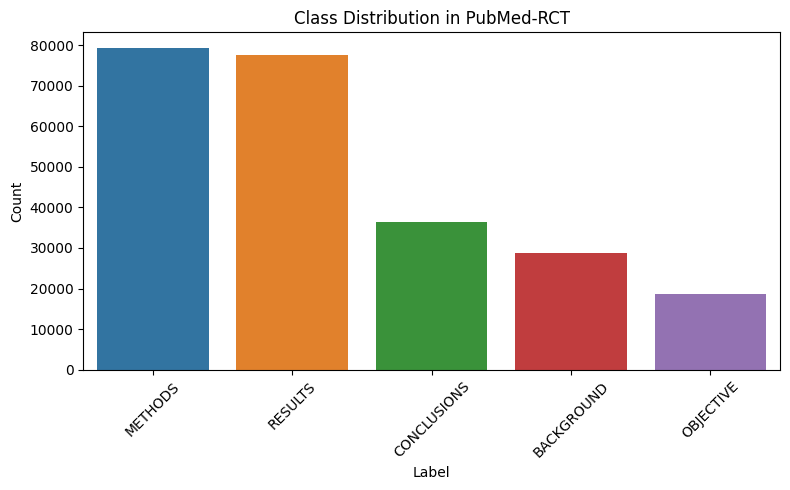

Train: 192309 Val: 24039 Test: 24039
Labels: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

Running SequenceMatch With 20000 Labeled Training Samples


PubMedRCT_20000_SeqMatch Epoch[1/3] TrainLoss=0.9611, Sup=0.5712, Unsup=0.4874, TrainAcc=79.69% ValLoss=0.4927, ValAcc=83.47%


PubMedRCT_20000_SeqMatch Epoch[2/3] TrainLoss=0.7642, Sup=0.4493, Unsup=0.3935, TrainAcc=85.30% ValLoss=0.4591, ValAcc=85.45%


PubMedRCT_20000_SeqMatch Epoch[3/3] TrainLoss=0.7008, Sup=0.3936, Unsup=0.3841, TrainAcc=86.97% ValLoss=0.4686, ValAcc=85.58%

PubMedRCT_20000_SeqMatch Final Test Results:
Test Accuracy: 85.12%
ROC AUC: 0.9699, Average Precision: 0.8560
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.69      0.69      2879
 CONCLUSIONS       0.79      0.80      0.79      3632
     METHODS       0.91      0.95      0.93      7922
   OBJECTIVE       0.71      0.58      0.64      1855
     RESULTS       0.90      0.91      0.90      7751

    accuracy                           0.85     24039
   macro avg       0.80      0.78      0.79     24039
weighted avg       0.85      0.85      0.85     24039

Model weights saved => SequenceMatch_PubMedRCT_20000_labeled.pth


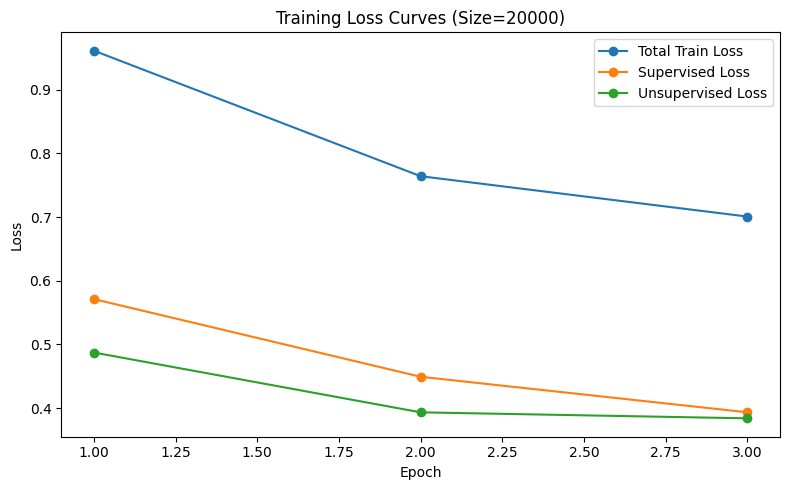

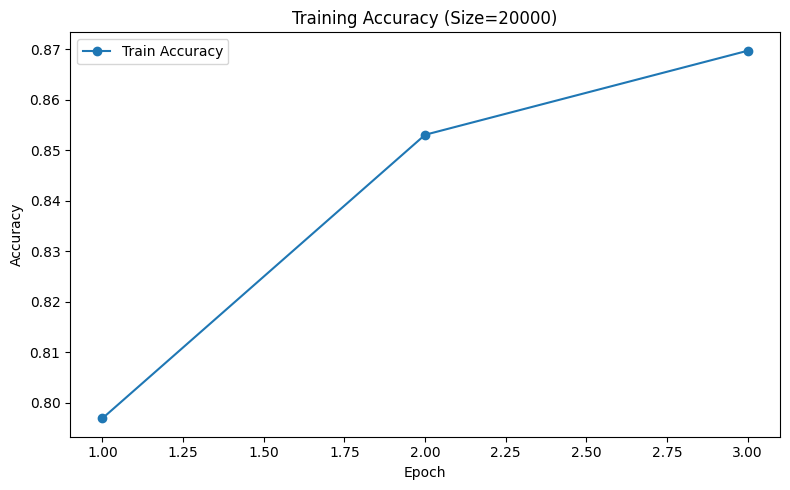

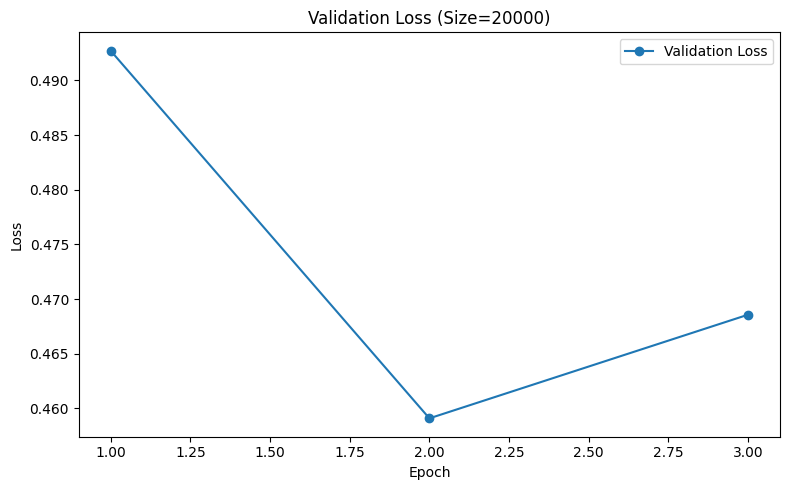

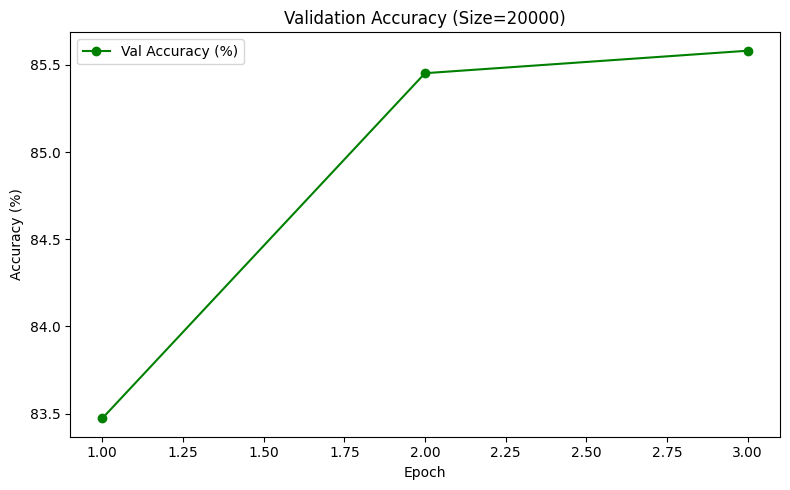

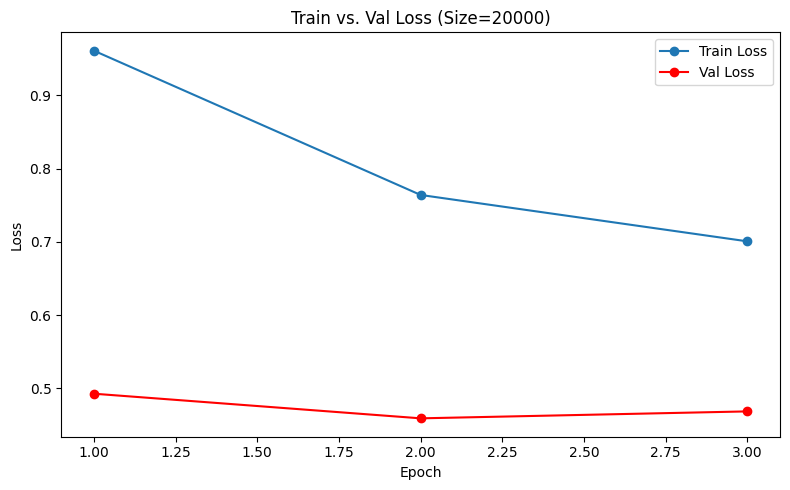

--- Finished Plotting For 20000 Labeled Samples ---


Running SequenceMatch With 40000 Labeled Training Samples


PubMedRCT_40000_SeqMatch Epoch[1/3] TrainLoss=0.8848, Sup=0.5343, Unsup=0.4380, TrainAcc=81.64% ValLoss=0.4785, ValAcc=84.57%


PubMedRCT_40000_SeqMatch Epoch[2/3] TrainLoss=0.7457, Sup=0.4408, Unsup=0.3811, TrainAcc=85.58% ValLoss=0.4552, ValAcc=86.09%


PubMedRCT_40000_SeqMatch Epoch[3/3] TrainLoss=0.6850, Sup=0.3912, Unsup=0.3673, TrainAcc=87.58% ValLoss=0.4740, ValAcc=86.14%

PubMedRCT_40000_SeqMatch Final Test Results:
Test Accuracy: 86.01%
ROC AUC: 0.9720, Average Precision: 0.8641
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.73      0.71      2879
 CONCLUSIONS       0.81      0.82      0.81      3632
     METHODS       0.92      0.95      0.93      7922
   OBJECTIVE       0.73      0.56      0.63      1855
     RESULTS       0.91      0.91      0.91      7751

    accuracy                           0.86     24039
   macro avg       0.81      0.79      0.80     24039
weighted avg       0.86      0.86      0.86     24039

Model weights saved => SequenceMatch_PubMedRCT_40000_labeled.pth


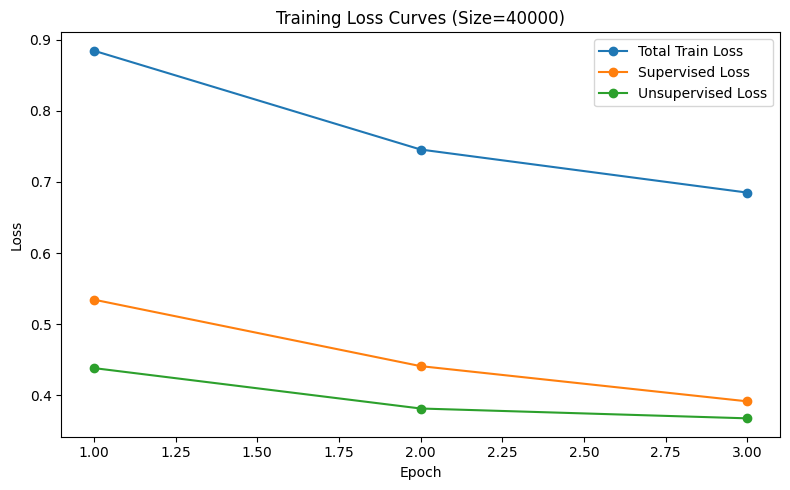

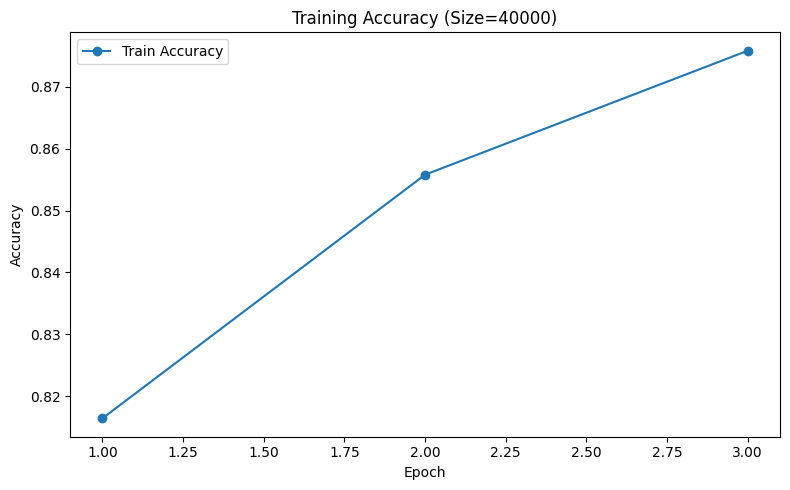

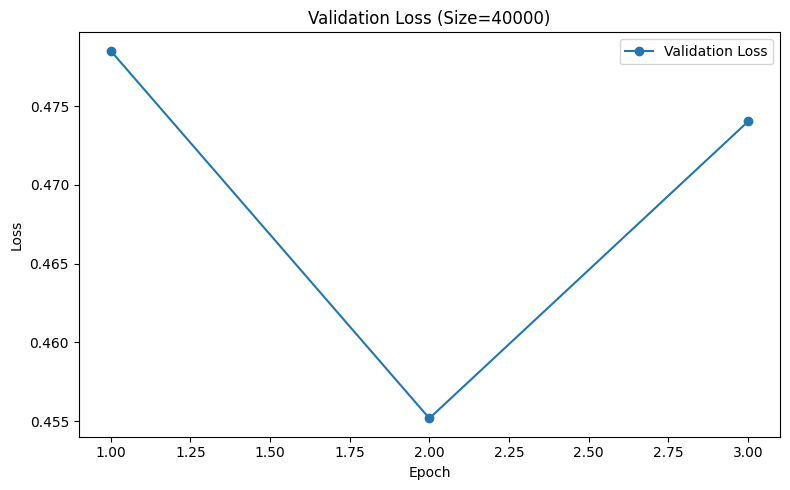

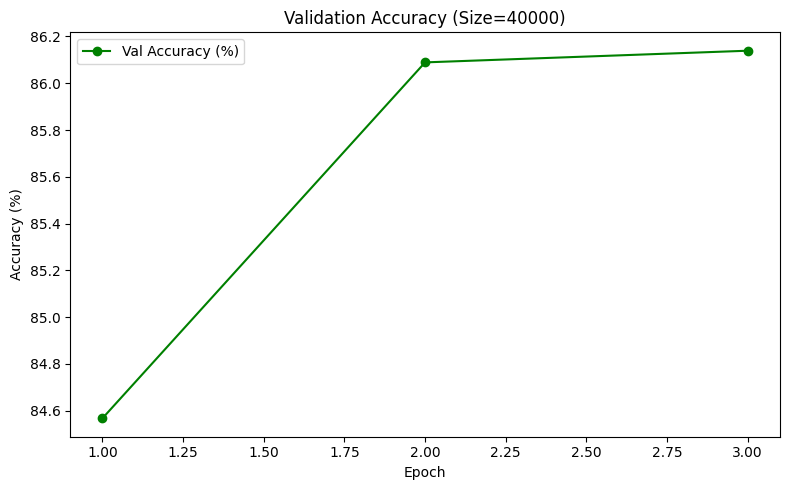

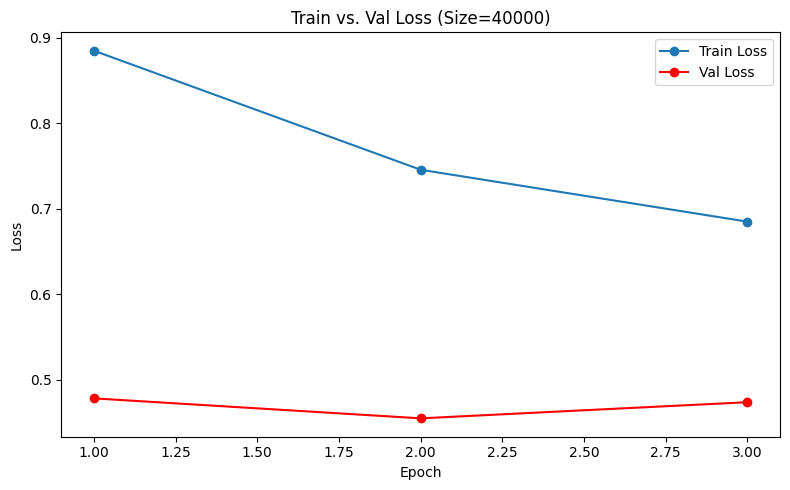

--- Finished Plotting For 40000 Labeled Samples ---


Running SequenceMatch With 80000 Labeled Training Samples


PubMedRCT_80000_SeqMatch Epoch[1/3] TrainLoss=0.8473, Sup=0.5157, Unsup=0.4145, TrainAcc=82.83% ValLoss=0.4680, ValAcc=85.87%


PubMedRCT_80000_SeqMatch Epoch[2/3] TrainLoss=0.7229, Sup=0.4344, Unsup=0.3607, TrainAcc=86.45% ValLoss=0.5066, ValAcc=86.51%


PubMedRCT_80000_SeqMatch Epoch[3/3] TrainLoss=0.6863, Sup=0.4046, Unsup=0.3522, TrainAcc=87.65% ValLoss=0.5054, ValAcc=86.78%

PubMedRCT_80000_SeqMatch Final Test Results:
Test Accuracy: 86.50%
ROC AUC: 0.9733, Average Precision: 0.8699
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.71      0.72      0.72      2879
 CONCLUSIONS       0.82      0.83      0.82      3632
     METHODS       0.92      0.95      0.94      7922
   OBJECTIVE       0.73      0.57      0.64      1855
     RESULTS       0.91      0.92      0.92      7751

    accuracy                           0.87     24039
   macro avg       0.82      0.80      0.81     24039
weighted avg       0.86      0.87      0.86     24039

Model weights saved => SequenceMatch_PubMedRCT_80000_labeled.pth


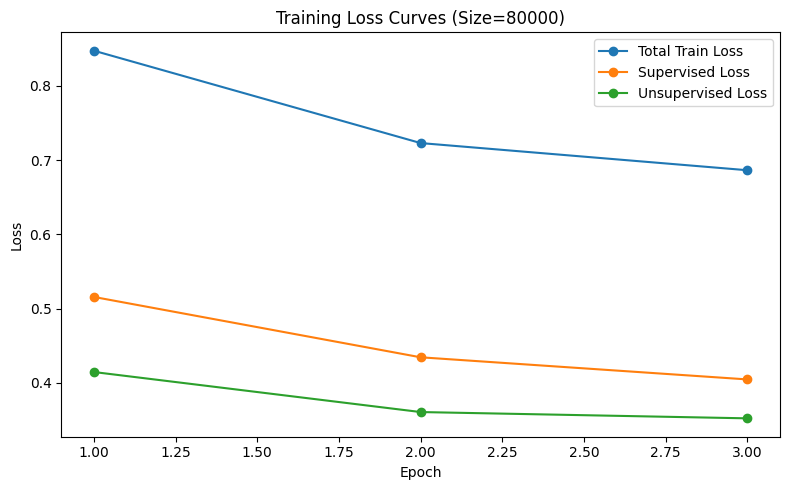

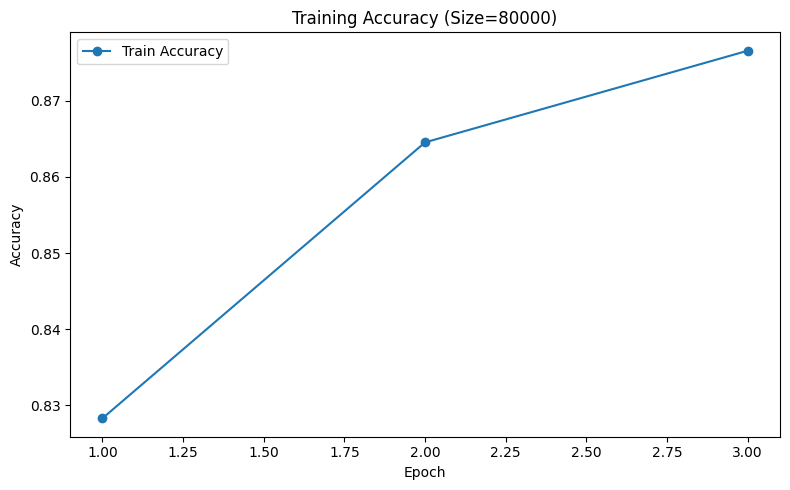

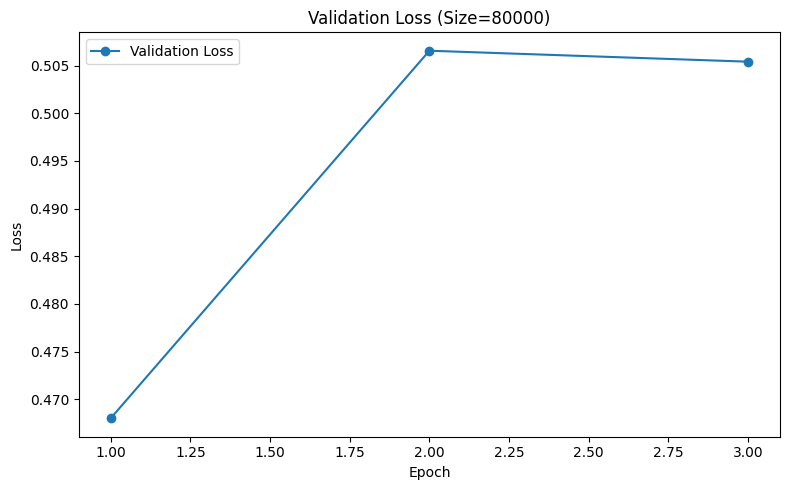

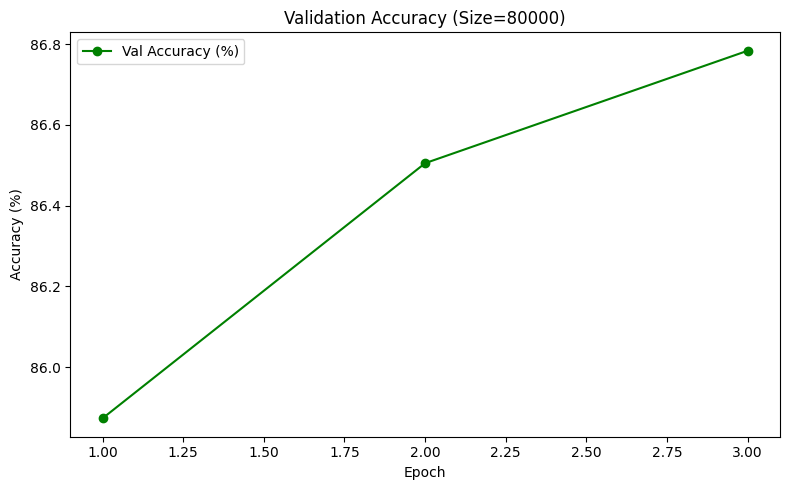

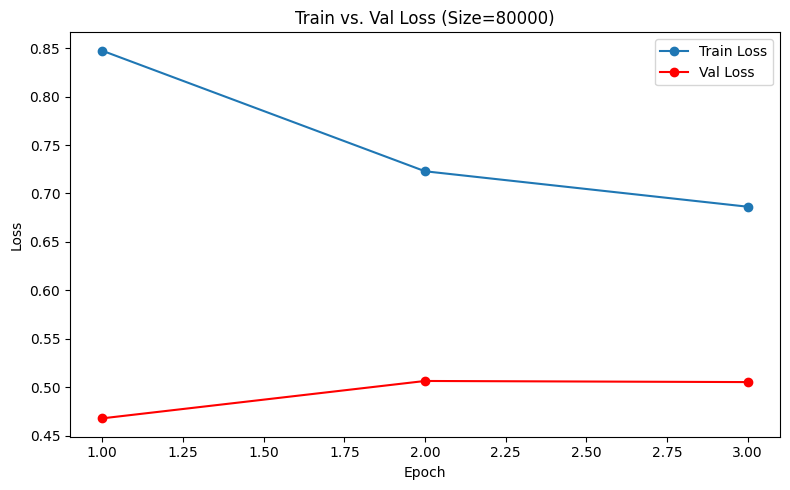

--- Finished Plotting For 80000 Labeled Samples ---


Running SequenceMatch With 120000 Labeled Training Samples


PubMedRCT_120000_SeqMatch Epoch[1/3] TrainLoss=0.8209, Sup=0.5020, Unsup=0.3987, TrainAcc=83.29% ValLoss=0.4593, ValAcc=86.25%


PubMedRCT_120000_SeqMatch Epoch[2/3] TrainLoss=0.7090, Sup=0.4336, Unsup=0.3442, TrainAcc=86.60% ValLoss=0.5223, ValAcc=86.83%


PubMedRCT_120000_SeqMatch Epoch[3/3] TrainLoss=0.6683, Sup=0.4062, Unsup=0.3276, TrainAcc=87.94% ValLoss=0.5355, ValAcc=86.96%

PubMedRCT_120000_SeqMatch Final Test Results:
Test Accuracy: 86.82%
ROC AUC: 0.9734, Average Precision: 0.8714
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.71      0.74      0.73      2879
 CONCLUSIONS       0.82      0.83      0.82      3632
     METHODS       0.92      0.96      0.94      7922
   OBJECTIVE       0.75      0.56      0.64      1855
     RESULTS       0.92      0.92      0.92      7751

    accuracy                           0.87     24039
   macro avg       0.82      0.80      0.81     24039
weighted avg       0.87      0.87      0.87     24039

Model weights saved => SequenceMatch_PubMedRCT_120000_labeled.pth


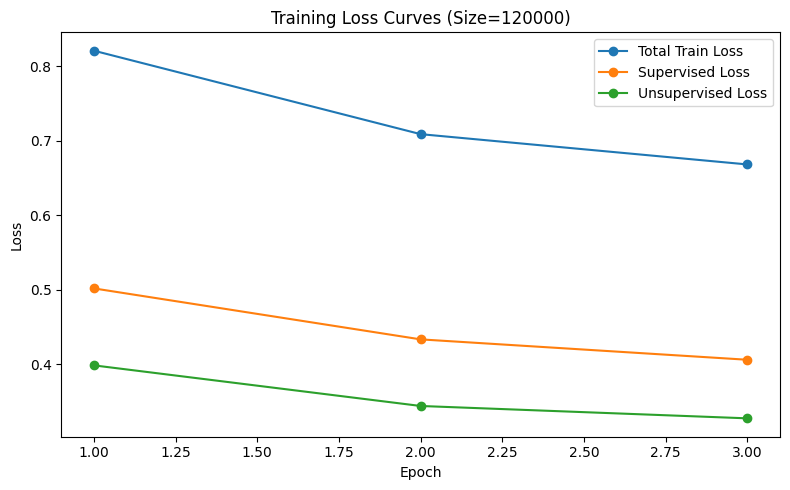

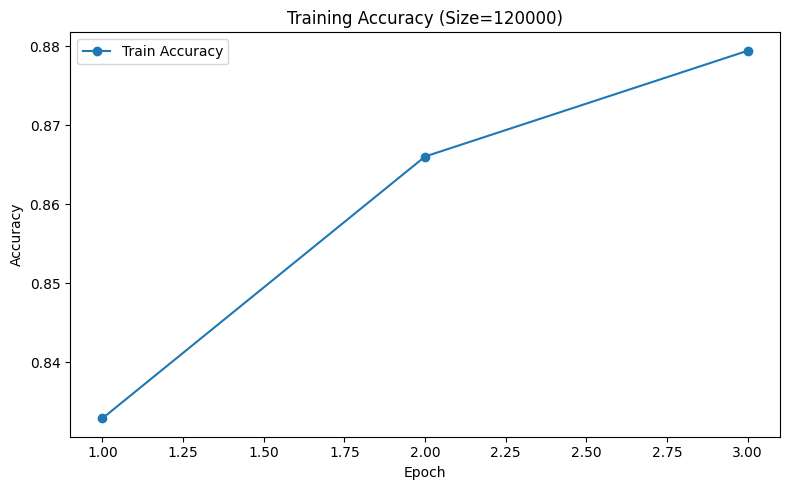

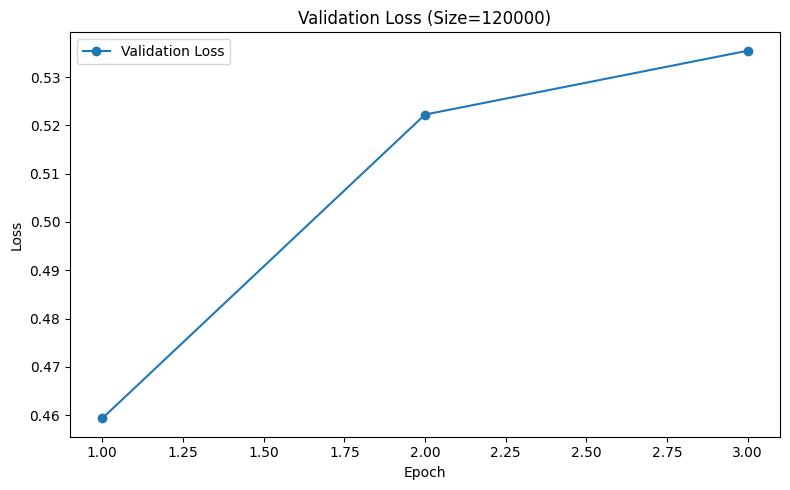

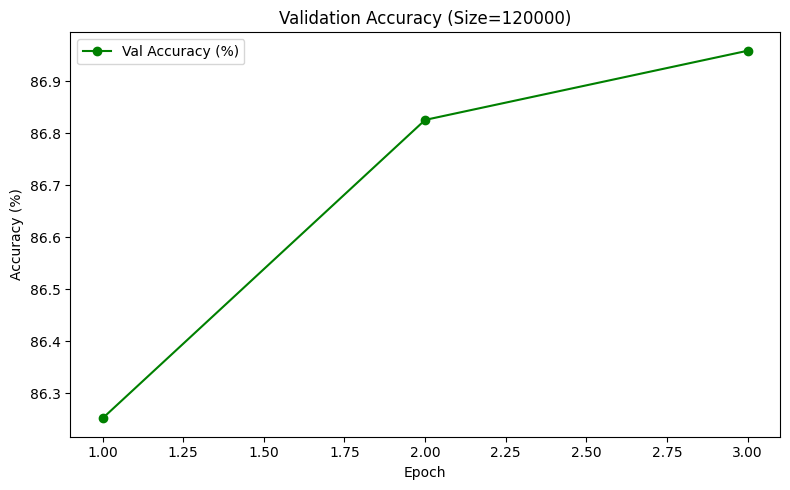

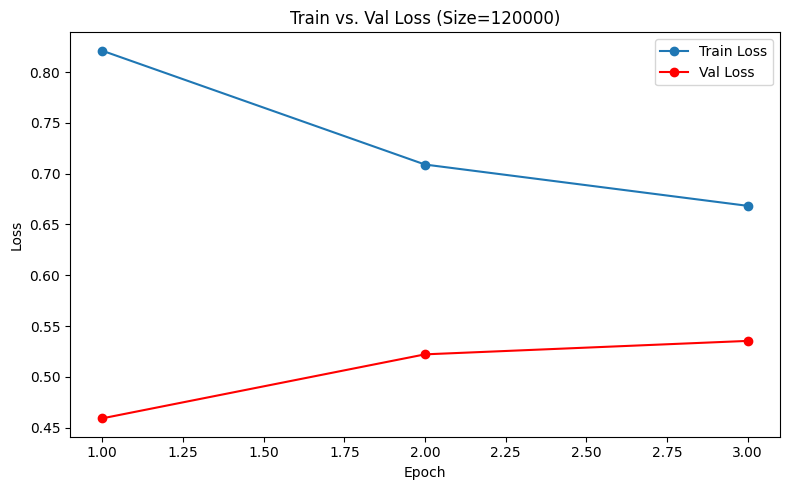

--- Finished Plotting For 120000 Labeled Samples ---


Best Run => 120000 Labeled Samples with Test Accuracy=86.82%


In [ ]:
if __name__ == "__main__":
    from multiprocessing import freeze_support
    freeze_support()
    Main()